# 딥러닝 (Week 5. Ensemble Learning & Random Forest)

by Kyoungwon Seo (Dept. of Applied Artificial Intelligence, SeoulTech)
- e: kwseo@seoultech.ac.kr
- w: https://hai.seoultech.ac.kr

강의계획
1. 투표 기반 분류기
2. 배깅과 페이스팅
3. 랜덤 패치와 랜덤 서브스페이스
4. 랜덤 포레스트
  - 엑스트라 트리
  - 특성 중요도
5. 부스팅
  - 에이다부스트
  - 그레디언트 부스팅
6. 스태킹

## 0. 배경

**1) 대중의 지혜 (wisdom of the crowd)**
- 무작위로 선택된 수천 명의 사람에게 모은 답 vs. 전문가 1인의 답
- 일련의 예측기들로부터 얻은 예측들의 종합 vs. 가장 좋은 모델 1개
- 앙상블(ensemble): 일련의 예측기들
- 앙상블 학습(ensemble learning)의 예
  - 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련
  - 개별 트리의 예측 계산
  - 트리들로부터 가장 많은 선택을 받은 클래스를 최종 예측으로 결정 (--> random forest) - 간단하지만 가장 강력한 머신러닝 알고리즘 중 하나 ♣ 머신러닝에서 가장 강력한 알고리즘 중 하나 : 앙상블, SVM

**Netflix Prize** 

(참조: https://en.wikipedia.org/wiki/Netflix_Prize)

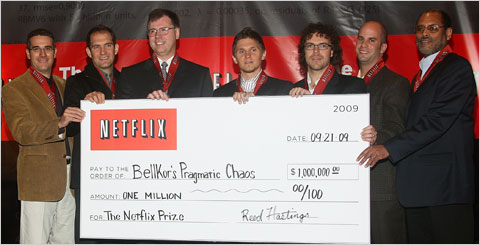

- An open competition for the best collaborative filtering algorithm to predict user ratings for films
- Netflix provided a training data set of 100,480,507 ratings that 480,189 users gave to 17,770 movies
- Each training rating is a quadruplet of the form <user, movie, date of grade, grade>
- The Ensemble vs. BellKor

## 1. 투표 기반 분류기

### 1) 개념

**더 좋은 분류기를 만드는 매우 간단한 방법**
- 다양한 분류기들(예: 로지스틱 회귀, SVM 등)의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
- 이렇게 다수결 투표로 정해지는 분류기를 "직접 투표(hard voting)" 분류기라고 함 ♣♣
- 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음
- 약한 학습기(weak learner)일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기(strong learner)가 될 수 있음
  - 약한 학습기(weak learner): 랜덤 추측보다 조금 더 높은 성능을 내는 분류기 ♣ 약한 학습기 반드시 기억
  - 강한 학습기(strong learner): 높은 정확도를 내는 분류기 ♣ 강한 학습기 반드시 기억

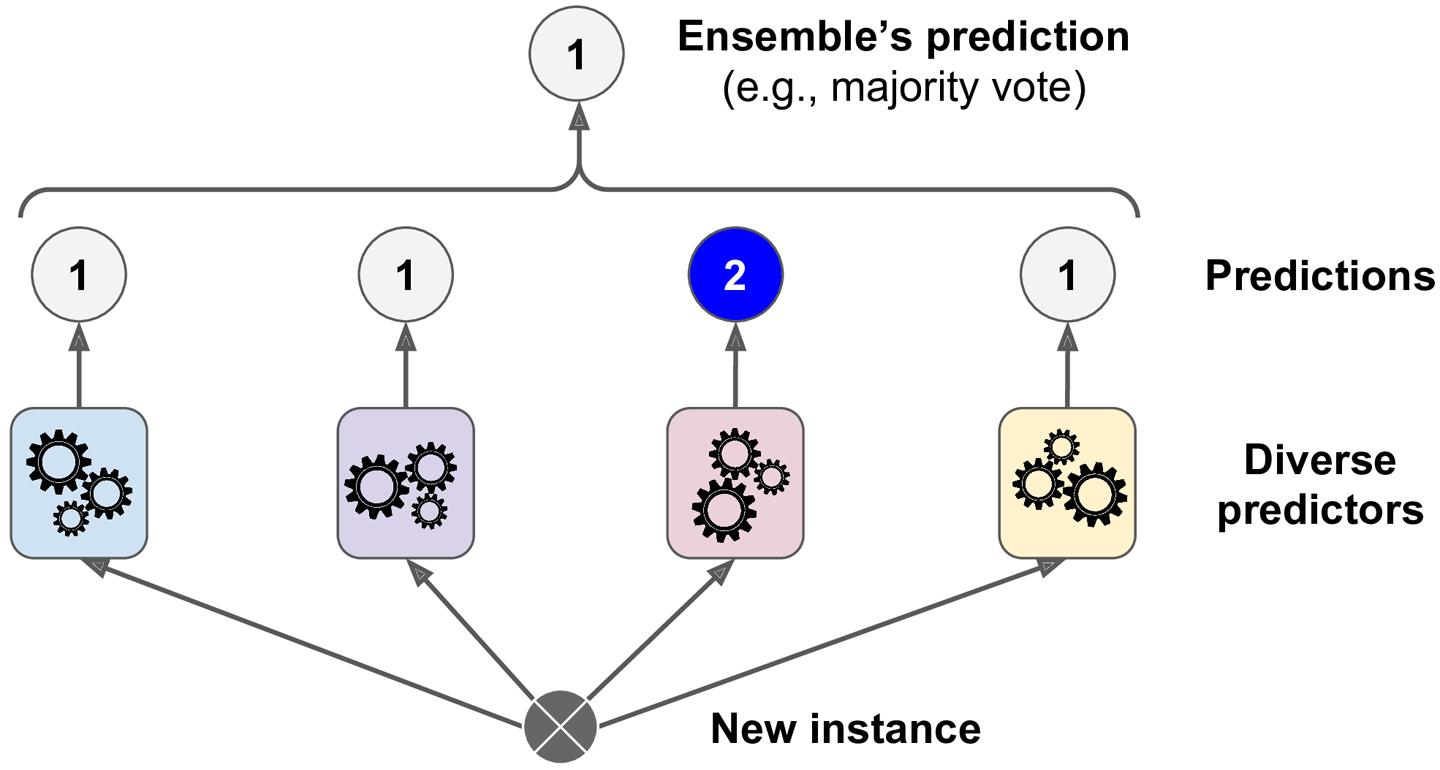

### 2) 원리

**이게 어떻게 가능할까?**
- 큰 수의 법칙(law of large numbers) - 참조: https://en.wikipedia.org/wiki/Law_of_large_numbers
  - The average of the results obtained from a large number of trials should be close to the expected value and tends to become closer to the expected value as more trials are performed
  - 예: 앞면이 51%, 뒷면이 49%가 나오는 균형이 맞지 않는 동전에 대한 실험 그래프

In [1]:
import numpy as np

heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

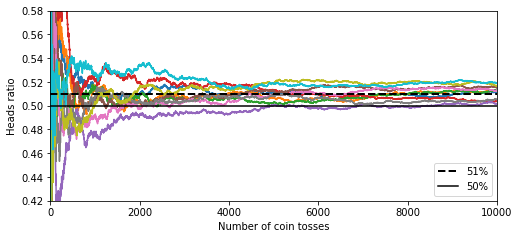

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])

plt.show()

**<큰 수의 법칙>**

- 위 확률은 이항분포(binomial distribution)의 확률 질량 함수(probability mass function)로 계산할 수 있음 ♣♣
- 이항 분포에서 n번의 시도 중 k번 성공할 확률을 사이 파이 속 이항 분포의 누적 분포 함수를 통해 계산해볼 수 있음 ♣♣
- 무작위 추축보다 조금 나은 51% 정확도를 가진 1,000개 분류기로 앙상블 모델을 구축할 경우 75% 정확도를 기대할 수 있음 ♣

In [3]:
from scipy.stats import binom

1-binom.cdf(499, 1000, 0.51) # 1,000번 던져서 앞면이 절반이상 나올 확률

0.7467502275563249

In [4]:
1-binom.cdf(4999, 10000, 0.51) # 10,000번 던져서 앞면이 절반이상 나올 확률

0.9777976478701103

### 3) 종류

### (1) 직접 투표 (hard voting)

#### 1] 주의사항

- 좋은 앙상블 모델을 위해서는 ♣
  - 모든 분류기가 완벽하게 독립적 ♣♣ 서로의 분류기가 종속적이라면, 한쪽으로 편향되는 경우가 많음
  - 오차에 상관관계가 없어야 함 ♣♣
- 그러나, 같은 데이터를 사용해 훈련시키기 때문에 위 조건을 만족시키기 힘듦 ♣♣

2] 사용
- 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 학습 ♣

- moons 데이터셋을 활용

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [7]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

- 개별 분류기와 투표 기반 분류기의 성능 비교

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


### (2) 간접 투표 (soft voting) ♣

1] 개념

- 모든 분류기가 클래스의 확률을 예측할 수 있으면(예: predict_proba() 메서드), 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있음 --> 이를 간접 투표(soft voting)

2] 특징

- 직접 투표 방식보다 성능이 높음 ♣♣
- 확률을 추정하기 위해 교차 검증을 사용하기 때문에 직접 투표와 비교해 훈련 속도가 느려짐 ♣♣

In [9]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42) # SVC는 기본적으로 확률 제공을 안하므로 probability=True로 설정

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [10]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


### 4) 분류기 생성

- 다양한 분류기를 만드는 방법
  - 분류기마다 각기 다른 훈련 알고리즘을 사용 ♣
  - 분류기들이 같은 알고리즘을 사용하는 대신, 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각각 다르게 학습 ♣
      - 배깅, 페이스팅

## 2. 배깅과 페이스팅

### 1) 종류

(1) 배깅(bagging) ♣ 성능이 좋음(편향을 줄일 수 있기 때문)
  - Bootstrap aggregating의 줄임말 (통계학에서 중복을 허용한 resampling을 bootstrapping 이라고 함)
  - 훈련 세트에서 중복을 허용하여 샘플링하는 방식
  - 참조: https://link.springer.com/article/10.1007/BF00058655

(2) 페이스팅(pasting) ♣ 학습 시간이 오래걸림
  - 중복을 허용하지 않고 샘플링하는 방식
  - 참조: https://link.springer.com/article/10.1023/A:1007563306331

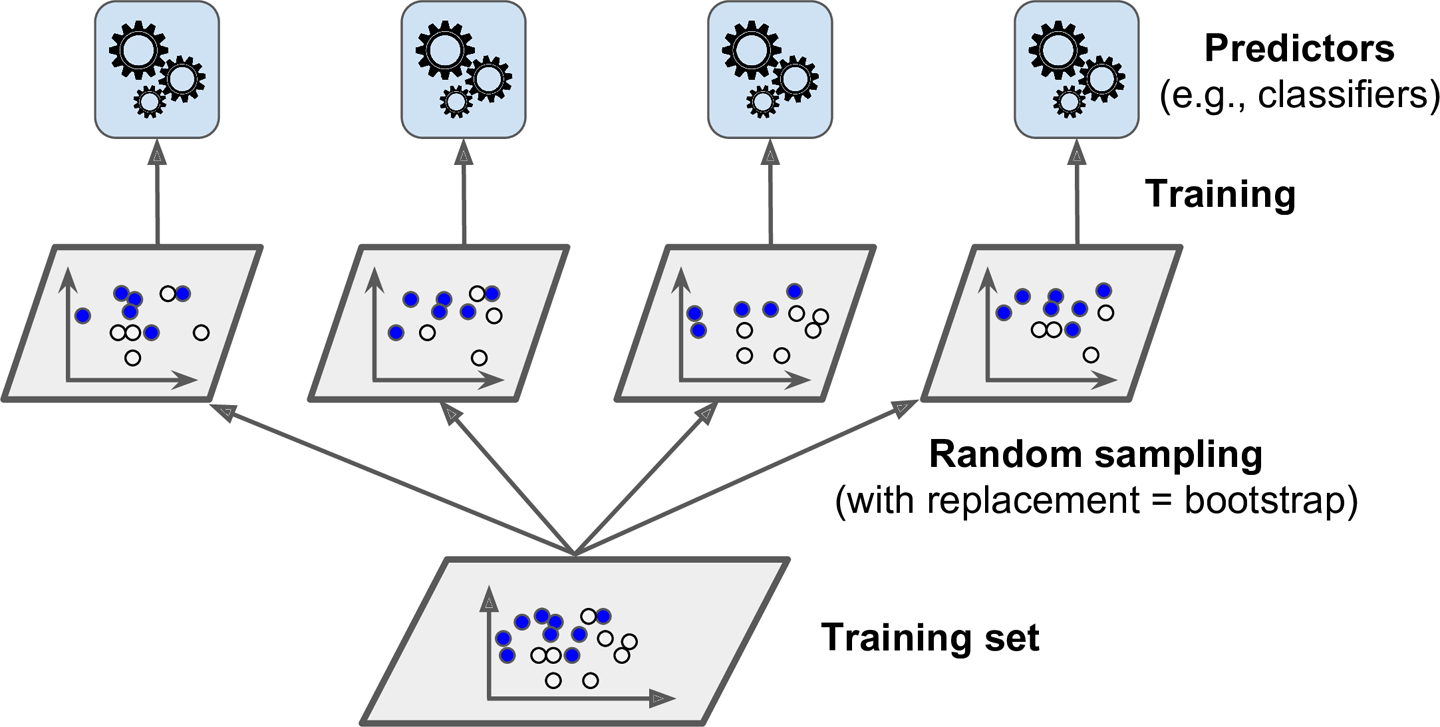

### 2) 특징

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 수행
- 이때 수집함수는 분류일 때 통계적 최빈값(statistical mode), 회귀일 때 평균의 계산 ♣♣♣
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함 ♣♣♣ 큰 수의 법칙 때문
- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦 ♣♣♣ 편향과 분산 사이의 trade-off 해결

### 3) 사이킷런의 배깅과 페이스팅

#### (1) 사용
- BaggingClassifier 사용 (회귀일 경우 BaggingRegressor) ♣

- 아래는 500개의 트리로 만든 배깅 앙상블

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


- 단일 결정 트리

In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [14]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

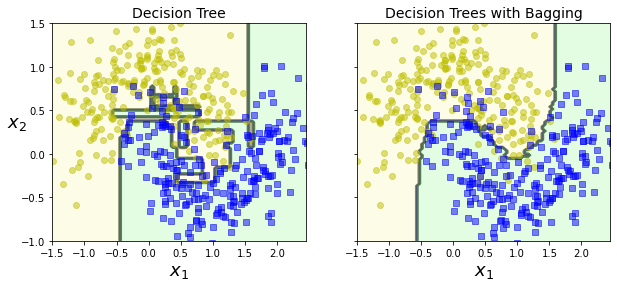

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")

plt.show()

**<단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교>**

- 앙상블이 결정 트리 하나의 예측보다 일반화가 훨씬 잘된 것 같음
- 앙상블은 비슷한 편향에서 더 작은 분산을 만듦 (훈련 세트의 오차 수는 거의 비슷하지만 결정 경계가 덜 불규칙함) ♣

- 일반적으로 배깅이 페이스팅 보다 나은 모델을 만듦
- 그러나 교차 검증으로 모두 평가해서 더 나은 쪽을 선택하는 것이 좋음 (NFT!) ♣

### 4) oob 평가 ♣

- 배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음
- 참조: https://goo.gl/ifFbg3
- 선택되지 않은 훈련 샘플들을 oob(out-of-bag) 샘플이라고 부름 (예측기마다 남겨진 oob는 모두 다름)
- 이러한 oob 샘플을 검증에 활용할 수 있음 (oob_score=True로 설정) ♣♣♣

In [16]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

- 테스트 세트에서의 정확도도 oob 평가 결과와 유사함

In [17]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

- oob 샘플에 대한 결정 함수의 값을 oob_decision_function 변수에서 확인할 수 있음

In [18]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

## 3. 랜덤 패치와 랜덤 서브스페이스

### 1) 특성, 샘플 샘플링

- BaggingClassifier는 max_features, bootstrap_features 두 매개변수를 조절해 특성 샘플링을 할 수 있음 ♣♣♣
- 이를통해 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨 ♣
  - (이미지와 같은) 고차원의 데이터셋을 다룰 때 유용
  - 아래 두가지 방식 존재

### 2) 종류

(1) 랜덤 패치 방식(random patches method) ♣♣♣
  - 훈련 특성과 샘플을 모두 샘플링 하는 것
  - 참조: https://link.springer.com/chapter/10.1007/978-3-642-33460-3_28

(2) 랜덤 서브스페이스 방식(random subspaces method) ♣♣♣
  - 훈련 샘플을 모두 사용하고 특성은 샘플링 하는 것
  - 특성 샘플링은 더 다양한 예측기를 만듦으로써 편향을 늘리는 대신 분산을 낮출수 있음
  - 참조: https://ieeexplore.ieee.org/abstract/document/709601?casa_token=_BuqL7ogEckAAAAA:bi4i4-WYESk39qyMLHluBlYE6bjuJoMIKczxKQtfySVkJWIgCeqJ-xiiMa3cmanmSaPHe-z2vw

## 4. 랜덤 포레스트

### 1) 개념

- 랜덤 포레스트(random forest)는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블 ♣
- 참조: https://ieeexplore.ieee.org/abstract/document/598994?casa_token=dPcLgZKkfBIAAAAA:kwXBlI-xbm6xk19-AC9hus0m_CDU0Ocx5HAxsqTd0k_U2IOxnnz2y88TgWWF3cRYR4qBCgTjQQ

### 2) 특징

- 랜덤 포레스트 알고리즘 ♣
  - 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 "무작위"로 선택한 특성 후보 중에서 최선의 특성을 찾는 식으로 "무작위성"을 주입 ♣♣
  - "무작위성"을 통해 트리를 다양하게 만듦으로써 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄 ♣♣

- 아래는 15개 결정 트리의 결정 경계를 중첩한 것 (개별 결정 트리는 불완전하지만 앙상블되면 매우 좋은 결정 경계를 만듦)

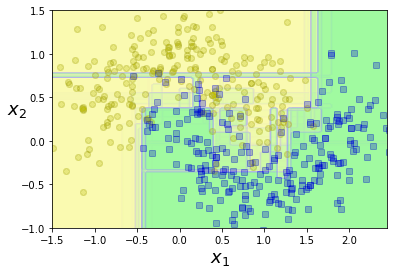

In [26]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X_train[indices_with_replacement], y_train[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

- 아래는 500개 트리로 이뤄진 랜덤 포레스트 분류기

In [19]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42) # ♣ 일종의 규제
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [20]:
y_pred_rf

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])

- 아래는 BaggingClassifier를 사용해 랜덤 포레스트 알고리즘과 거의 유사하게 만든 것

In [21]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [22]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 랜덤 포레스트 알고리즘과 BaggingClassifier 비교

In [23]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # 거의 에측이 동일

1.0

### 3) 트리 종류

### [1] 일반 트리 

### [2] 엑스트라 트리

#### 1] 특징 

**엑스트라 트리(extra-tres)** ♣
- 익스트림 랜덤 트리(extremely randomized trees) 앙상블의 줄임말
- 트리를 더욱 무작위하게 만들기 위해 (보통의 결정 트리처럼) 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택 ♣♣♣
- 편향이 늘어나지만 대신 분산을 낮출 수 있음 ♣♣♣
- 일반적 랜덤 포레스트보다 훨씬 빠름 (모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로) ♣♣
- 참조: https://link.springer.com/article/10.1007/s10994-006-6226-1

#### 2] 사용

- 사이킷런의 ExtraTreesClassifier 사용 ♣

#### 3] 비교

랜덤 포레스트 알고리즘 vs. 엑스트라 트리? ♣
- 둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법 (again, NFT!)
- 그 후, 그리드 탐색으로 하이퍼파라미터를 튜닝

### 4) 특성 중요도 (feature importance)

- 랜덤 포레스트의 장점 중 하나는 "특성의 상대적 중요도를 측정하기 쉽다는 것"
- 사이킷런은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지를 통해 특성의 중요도를 측정 ♣♣♣
  - (결정 트리의 특성 중요도) = (현재 노드의 샘플 비율 * 불순도) - (왼쪽 자식 노드의 샘플 비율 * 불순도) - (오른쪽 자신 노드의 샘플 비율 * 불순도) 계산
  - 특성 중요도의 합이 1이 되도록 전체 합으로 나누어 정규화

- iris 데이터셋에 대한 RandomForestClassifier의 특성 중요도

In [24]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [25]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

- 아래는 MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 나타낸 것 ♣

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [28]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

In [32]:
import matplotlib as mpl

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

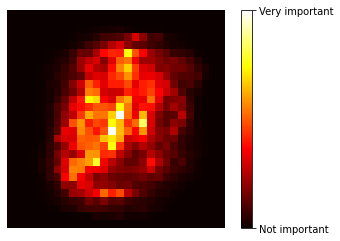

In [33]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

**<(랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도>**

## 5. 부스팅

### 1) 개념

- 부스팅(boosting) ♣
  - 가설 부스팅(hypothesis boosting)의 줄임말 ♣
  - 약한 학습기를 여러개 연결하여 강한 학습기를 만드는 앙상블 방법 ♣
  - 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
  - 대표적 방법으로 에이다부스트(AdaBoost)와 그레이디어트 부스팅(gradient boosting)이 있음

### 2) 종류

### (1) 에이다부스트(AdaBoost)

#### 1] 개념

- Adaptive boosting의 줄임말 ♣
- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임으로써 새로운 예측기가 학습하기 어려운 샘플에 점점 더 맞춰지게 하는 것 ♣♣♣ 온라인 학습에 유용하게 사용됨
- 참조: https://www.sciencedirect.com/science/article/pii/S002200009791504X

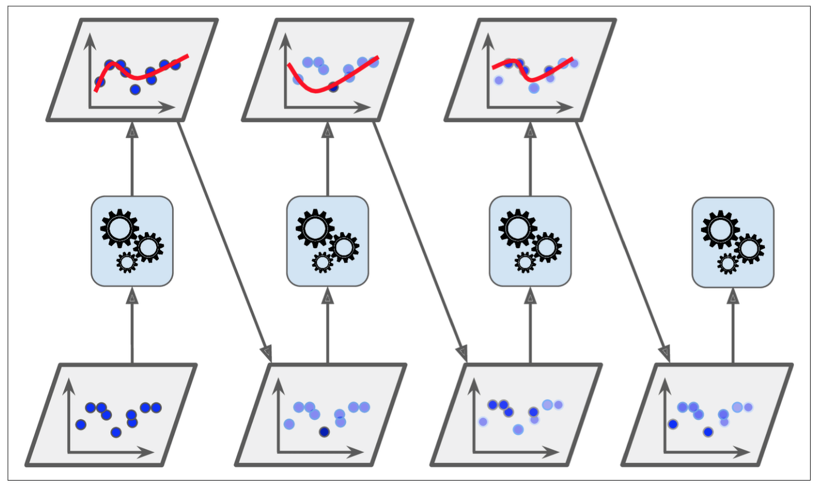

- moons 데이터셋에 규제를 강하게 한 RBF 커널 SVM 분류기를 AdaBoost를 학습시킨 예제
  - 주의: 이는 예시임. SVM은 속도가 느려서 AdaBoost와 함께 사용하기에 부적합 ♣

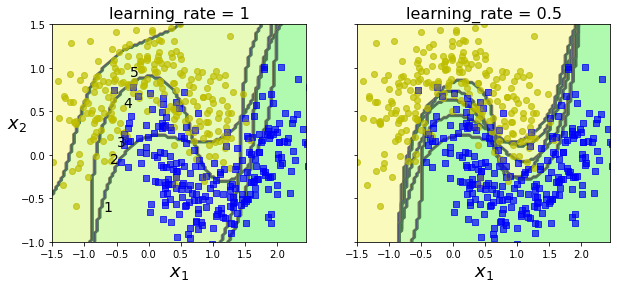

In [34]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

**<연속된 예측기의 결정 경계>**

#### 2] 특징

- 위와 같은 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음 ♣♣♣
  - 다만 경사 하강법은 비용 함수 최소화를 위해 단일 예측기의 모델 파라미터를 조정하는 반면
  - AdaBoost는 앙상블에 새로운 예측기를 추가함

- 모든 예측기가 훈련을 마치면 이 앙상블은 배깅, 페이스팅과 비슷한 방식으로 예측을 만듦 ♣♣♣
- 예측기마다 다른 가중치가 적용됨 ♣♣
- AdaBoost의 단점: 각 예측기는 이전 예측기가 훈련되고 평가된 후에 학습될 수 있기 때문에 병렬화(또는 분할)를 할 수 없음 --> 속도 문제로 배깅/페이스팅만큼 확장성이 높지 않음 ♣♣

#### 3] 순서

- AdaBoost 알고리즘 속 계산

[1] $r_j$ : j번째 예측기의 가중치가 적용된 에러율 ♣♣
  - 첫 번째 예측기가 학습되고 가중치가 적용된 에러율 $r_1$이 훈련 세트에 대해 계산됨

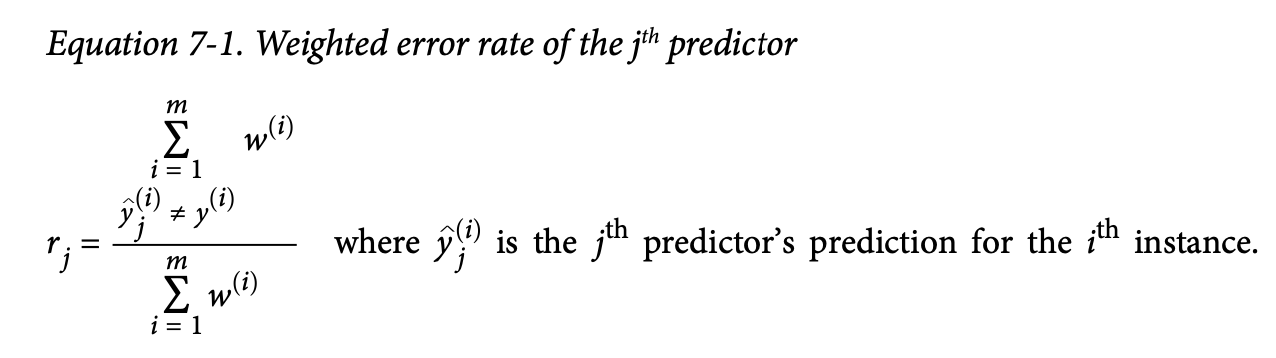

(hat : 예측값 / hat이 없는 경우 : 참값)

[2] $a_j$ : j번째 예측기의 가중치 ♣♣♣
  - 에러율을 바탕으로 해당 예측기의 가중치를 계산 

- 예측기가 정확할수록 가중치가 높아지게 됨(에러율 r < 0.5 -> 예측기 가중치 a > 0)
- 만약 무작위로 예측하는 정도라면 가중치가 0에 가까울 것(에러율 r = 0.5 -> 예측기 가중치 a = 0)
- 무작위 예측보다 나쁘면 가중치는 음수가 됨(에러율 r > 0.5 -> 예측기 가중치 a < 0)

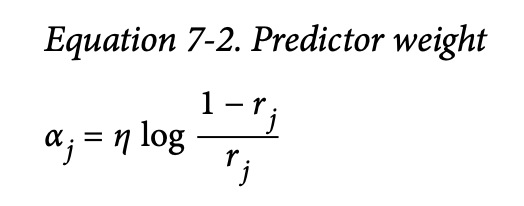

[3] w(i) : 샘플의 가중치 ♣♣♣
- 샘플의 가중치 업데이트 (즉, 잘못 분류된 샘플의 가중치가 증가)

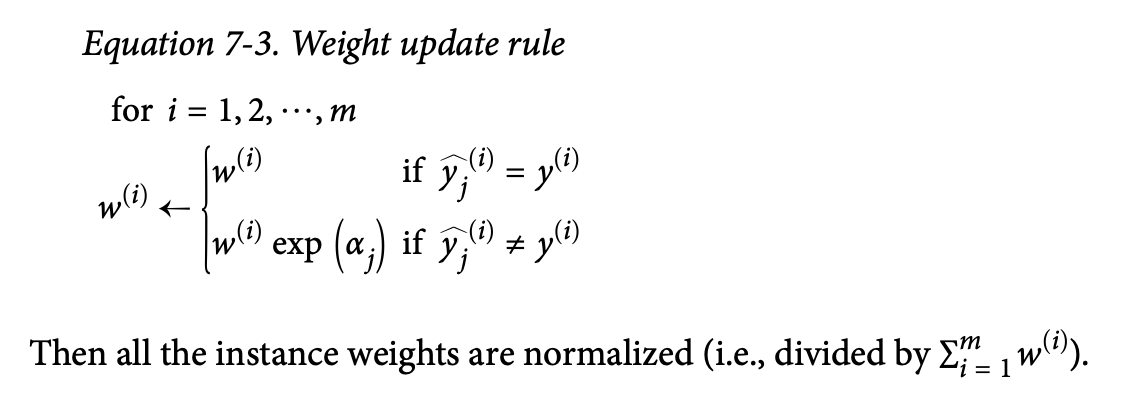

[4] 위 과정 반복 ♣♣♣
- 새 예측기가 업데이트된 가중치를 사용해 훈련하고 위 과정이 반복됨

[5] AdaBoost 알고리즘의 중단 ♣♣♣
- 지정된 예측기 수에 도달할 경우
- 완벽한 예측기가 만들어질 경우

[6] AdaBoost의 예측 ♣♣♣
- 모든 예측기의 예측을 계산하고 가중치를 더해 예측 결과를 만듦
- 가중치 합이 가장 큰 클래스가 예측 결과가 됨 ♣

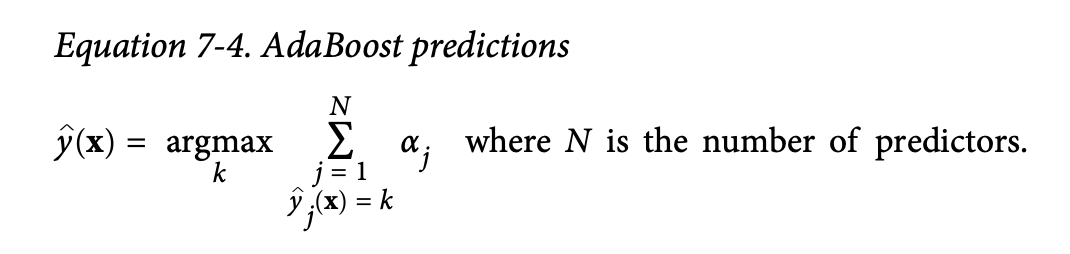

#### 4] 사용
- 사이킷런의 AdaBoostClassifier를 사용 ♣

- AdaBoostClassfier를 사용하여 200개의 아주 얕은 결정 트리(max_depth=1)를 기반으로 하는 AdaBoost 분류기 훈련

In [35]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

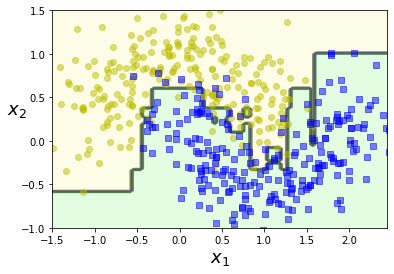

In [36]:
plot_decision_boundary(ada_clf, X, y)

#### 5] 과적합 대처

- AdaBoost 앙상블이 훈련 세트에 과적합할 경우 ♣♣♣
  - 추정기 수를 줄이거나 (아래 코드는 추정기 수를 100개로 줄임)
  - 추정기의 규제를 더 강하게 할 것

In [45]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=100,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=100, random_state=42)

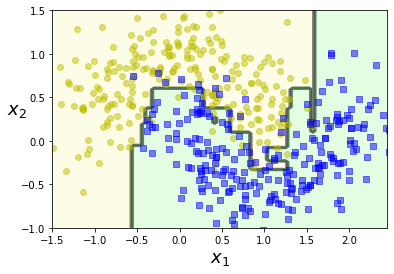

In [46]:
plot_decision_boundary(ada_clf, X, y)

### (2) 그레이디언트 부스팅

#### 1] 개념

- 그레이디언트 부스팅(gradient boosting)
  - AdaBoost처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가
  - AdaBoost가 반복마다 샘플의 가중치를 수정한 반면, gradient boosting은 이전 예측기가 만든 "잔여 오차(residual error)"에 새로운 예측기를 학습 ♣♣♣
  - 참조1: https://www.stat.berkeley.edu/~breiman/arcing-the-edge.pdf
  - 참조2: https://www.jstor.org/stable/2699986#metadata_info_tab_contents

#### 2] 종류

[1] 그레이디언트 트리 부스팅(gradient tree boosting) ♣♣♣
  - 결정 트리를 기반 예측기로 사용하는 그레이디언트 부스팅
  - 그레이디언트 부스티드 회귀 트리(GBRT, gradient boosted regression tree)라고 함

- 간단한 이차식 형태 데이터를 활용한 예제

In [47]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

먼저 DescisionTreeRegressor를 훈련 세트에 학습

In [48]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

첫 번째 예측기에서 생긴 잔여 오차 y2에 두 번째 DecisionTreeRegressor를 훈련

In [49]:
y2 = y - tree_reg1.predict(X) # ♣
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

두 번째 예측기가 만든 잔여 오차에 세 번째 모델을 훈련

In [50]:
y3 = y2 - tree_reg2.predict(X) # ♣
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

세 개의 트리를 포함하는 앙상블 모델

In [51]:
X_new = np.array([[0.8]])

In [52]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [53]:
y_pred

array([0.75026781])

위 과정의 시각화

In [54]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

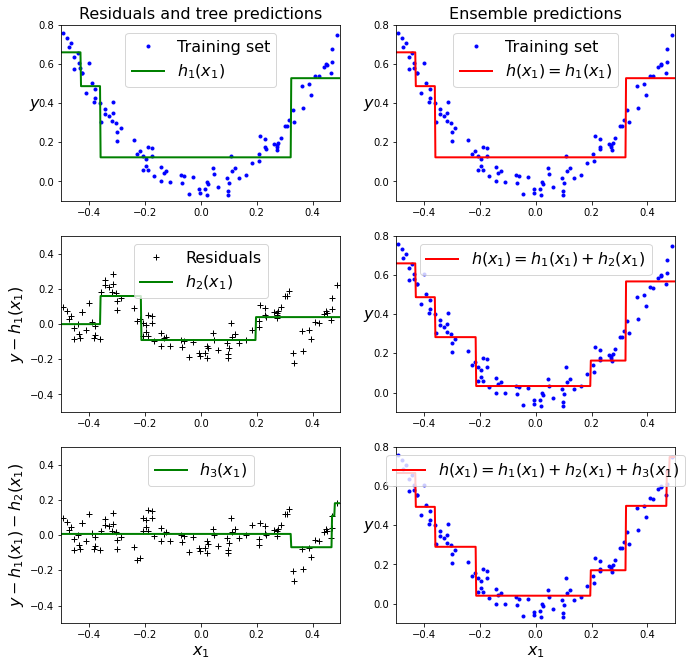

In [55]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

**<잔여 오차와 이를 반영한 그레이디언트 부스팅 그래프>** ♣

- 그레이디언트 부스팅 회귀 모델 예제 (예측기가 부족한 경우 vs. 너무 많은 경우)

In [56]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [57]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

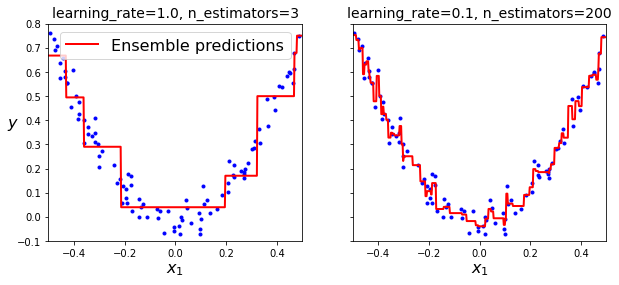

In [58]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**<예측기가 부족한 경우(왼쪽)과 너무 많은 경우(오른쪽)의 GBRT 앙상블>** ♣

#### 3] 과적합 대처

- 위 그림에서 learning_rate 매개변수는 각 트리의 기여 정도를 조절
- learning_rate=0.1로 낮게 설정하면 많은 트리가 필요하지만 일반적 예측 성능이 좋아짐 (축소 shrinkage 규제 방법) ♣♣
- 그러나 트리가 너무 많아지면 과대 적합이 발생함 ♣♣
  - 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용

- 조기 종료를 사용한 그레이디언트 부스팅 예제

In [59]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [60]:
min_error = np.min(errors)

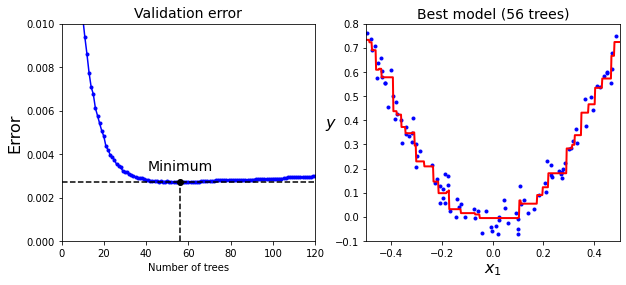

In [62]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

**<조기 종료를 사용하여 트리 수 튜닝>**

- 위처럼 많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾는 대신 "다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈추는 조기종료"를 사용할 수 있음
  - warm_start=True로 설정 (아래 예제 참조) ♣♣

In [63]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [64]:
print(gbrt.n_estimators)

61


In [65]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


#### 2] 종류 이어서

[2] 확률적 그레디언트 부스팅(stochastic gradient boosting) ♣♣ bias-variance trade-off 굉장히 중요하다!!! 매우 강조!!!

1]] 개념
- GBRT에서 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정 ♣♣♣

2]] 특징
- subsample 매개변수 사용 (subsample=0.25라고 하면 각 트리는 무작위로 선택된 25% 훈련 샘플로 학습) ♣♣♣
- 편향이 높아지는 대신 분산이 낮아짐
- 훈련 속도를 상당히 높임 ♣♣♣

[3] XGBoost 파이썬 라이브러리 ♣♣
  - 익스트림 그레이디언트 부스팅(extreme gradient boosting)의 약자
  - 참조: https://github.com/dmlc/xgboost

In [66]:
try:
    import xgboost
except ImportError as ex:
    print("에러: xgboost 라이브러리 설치되지 않았습니다.")
    xgboost = None

In [67]:
if xgboost is not None:  
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) 
    print("Validation MSE:", val_error)           

[06:04:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0028512559726563943


In [68]:
if xgboost is not None:  
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  
    print("Validation MSE:", val_error)            

[06:05:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.286719
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.258221
[2]	validation_0-rmse:0.232634
[3]	validation_0-rmse:0.210526
[4]	validation_0-rmse:0.190232
[5]	validation_0-rmse:0.172196
[6]	validation_0-rmse:0.156394
[7]	validation_0-rmse:0.142241
[8]	validation_0-rmse:0.129789
[9]	validation_0-rmse:0.118752
[10]	validation_0-rmse:0.108388
[11]	validation_0-rmse:0.100155
[12]	validation_0-rmse:0.09208
[13]	validation_0-rmse:0.084791
[14]	validation_0-rmse:0.078699
[15]	validation_0-rmse:0.073248
[16]	validation_0-rmse:0.069391
[17]	validation_0-rmse:0.066277
[18]	validation_0-rmse:0.063458
[19]	validation_0-rmse:0.060326
[20]	validation_0-rmse:0.0578
[21]	validation_0-rmse:0.055643
[22]	validation_0-rmse:0.053943
[23]	validation_0-rmse:0.053138
[24]	validation_0-rmse:0.052415
[25]	validation_0-rmse

In [69]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None

[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:05:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [70]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)

15.8 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 6. 스태킹

### 1) 개념

- 스태킹(stacking) ♣♣
  - Stacked generalization의 줄임말
  - 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수(직접 투표 같은)를 사용하는 대신 취합하는 모델을 훈련시킬 수 없을까?
    - 앙상블에 속한 예측기들의 결과를 입력으로 받아 최종 예측을 하는 새로운 예측기 블렌더(blender)또는 메타 학습기(meta learner)를 훈련시킴 ♣♣♣ 예측기를 예측
    - 참조: https://www.sciencedirect.com/science/article/pii/S0893608005800231

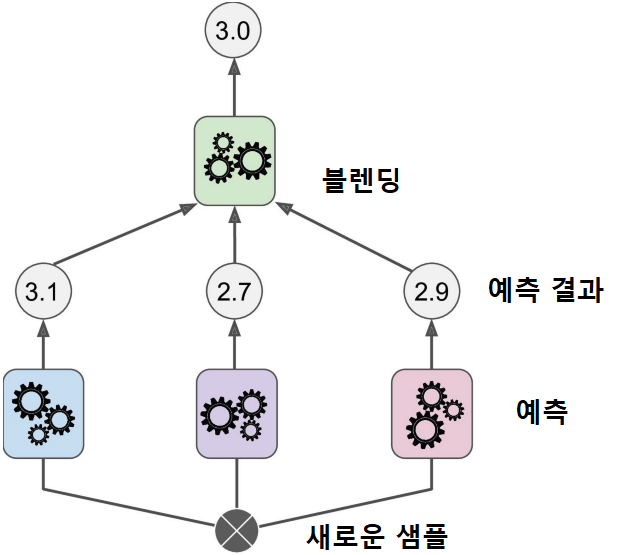

### 2) 순서

- 블렌더를 학습시키는 일반적 방법 ♣♣
  - 훈련 세트를 두 개의 서브셋으로 나눔
  - 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용
  - 첫 번째 레이어의 예측기를 사용해 두 번째 서브셋에 대해 예측하도록 학습

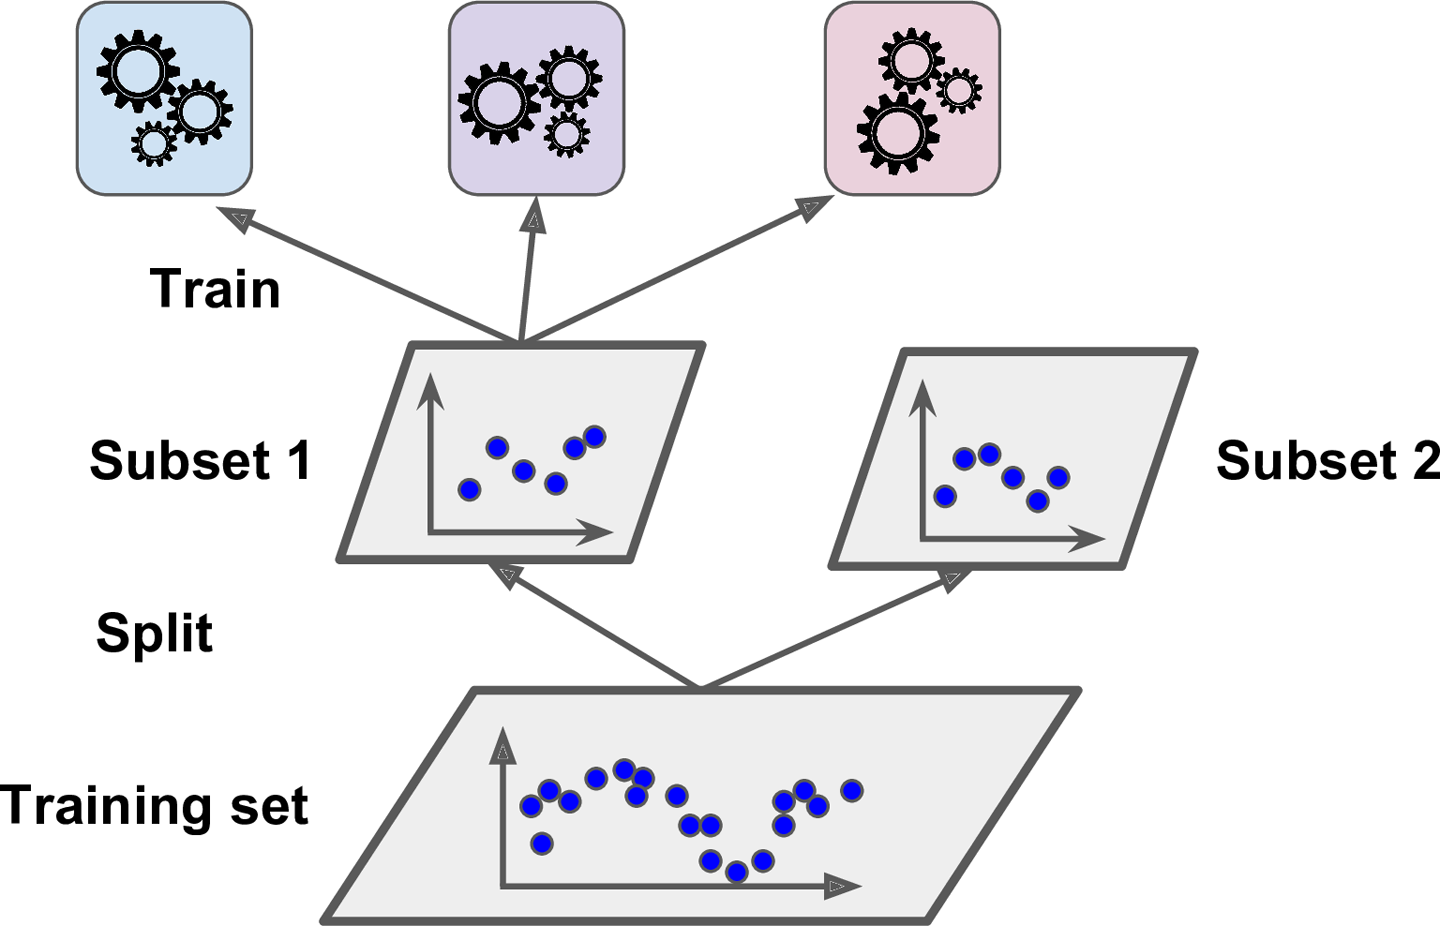

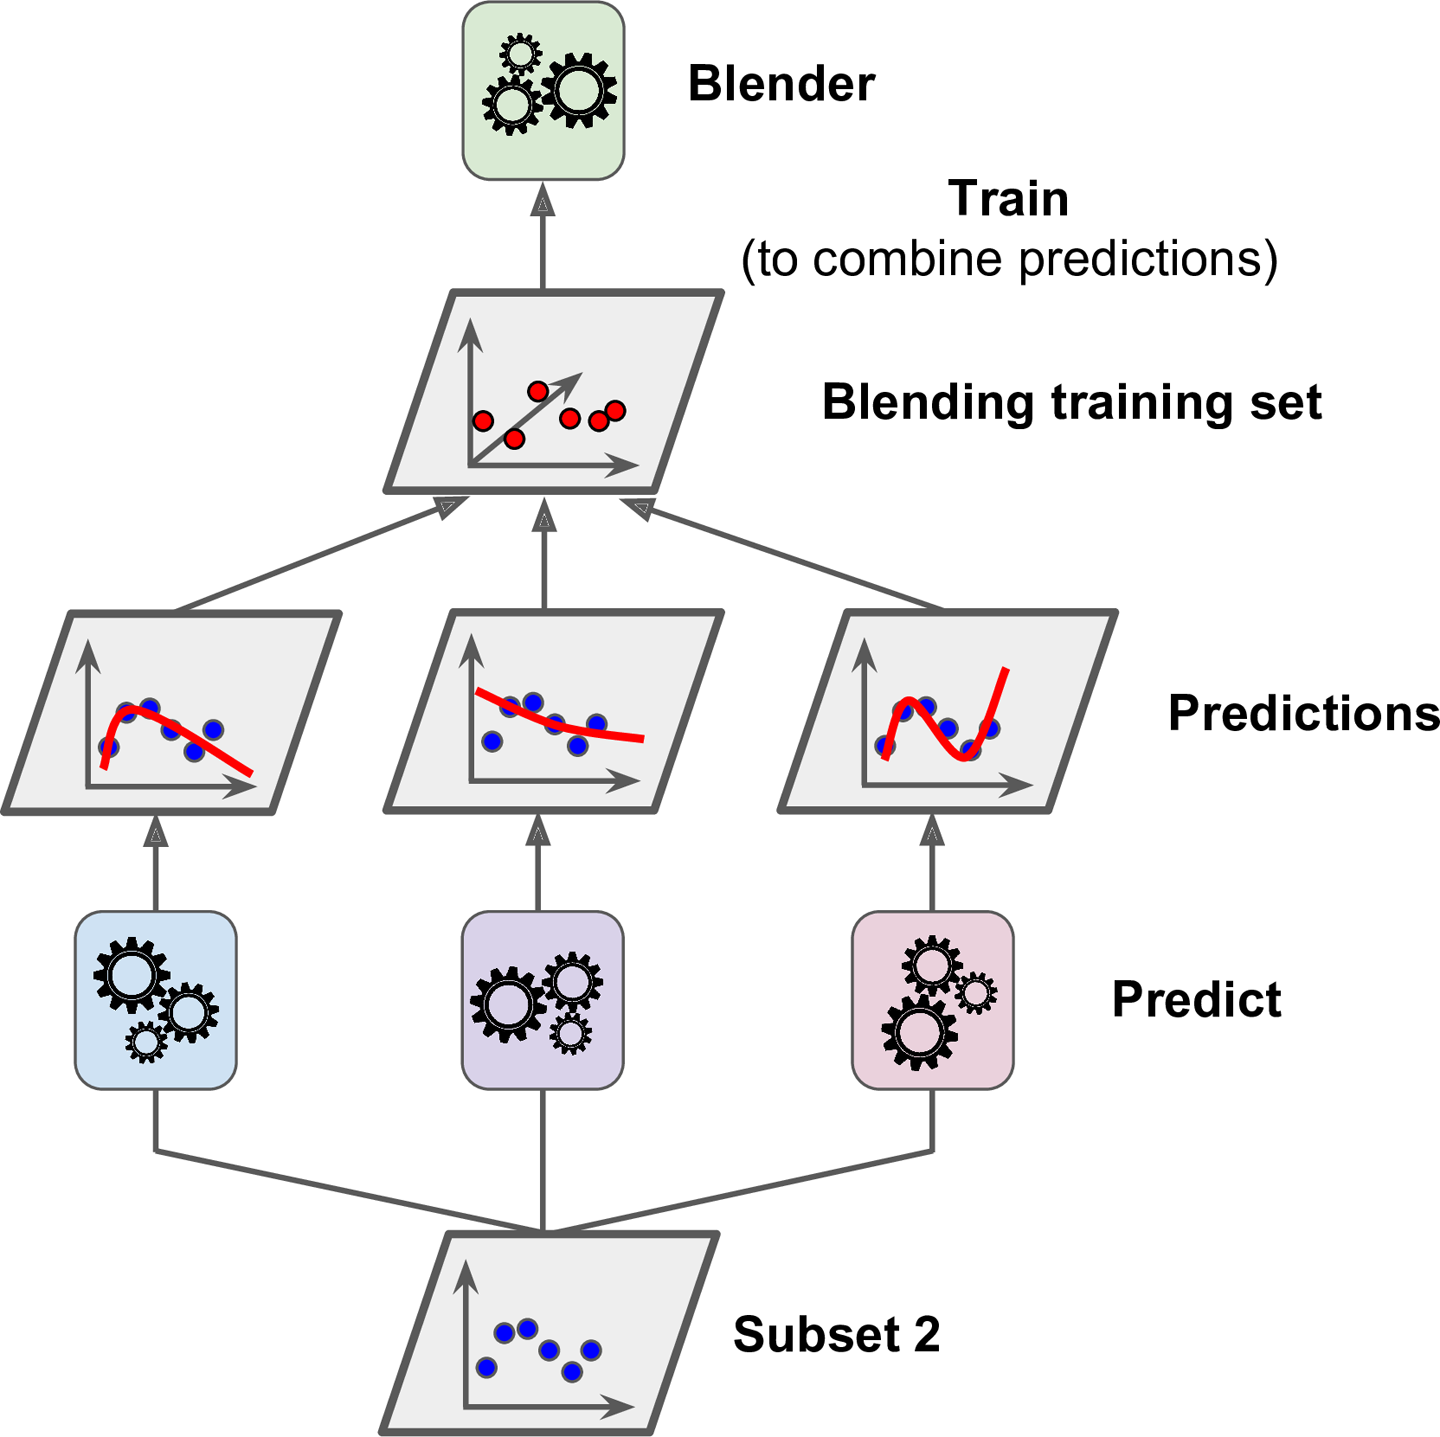

- 사이킷런의 이용한 스태킹 StackingClassifier, StackingRegressor
- DESlib 오픈 소스: https://github.com/Menelau/DESlib